# Step 2: Create Graph Embeddings - Cell-by-Cell Code

In [4]:
# !pip install torch-geometric
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f

##  Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, GATConv, to_hetero
from torch_geometric.transforms import ToUndirected
from torch_geometric.loader import NeighborLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## Load All Graph Files

In [2]:
# Load all graph-related CSV files
print("Loading graph files...")

graph_nodes_properties = pd.read_csv('graph_nodes_properties.csv')
graph_nodes_schools = pd.read_csv('graph_nodes_schools.csv')
graph_nodes_stations = pd.read_csv('graph_nodes_stations.csv')
graph_edges_property_school = pd.read_csv('graph_edges_property_school.csv')
graph_edges_property_station = pd.read_csv('graph_edges_property_station.csv')
graph_edges_station_station = pd.read_csv('graph_edges_station_station.csv')

print(f"✓ Property nodes: {len(graph_nodes_properties)}")
print(f"✓ School nodes: {len(graph_nodes_schools)}")
print(f"✓ Station nodes: {len(graph_nodes_stations)}")
print(f"✓ Property-School edges: {len(graph_edges_property_school)}")
print(f"✓ Property-Station edges: {len(graph_edges_property_station)}")
print(f"✓ Station-Station edges: {len(graph_edges_station_station)}")


Loading graph files...
✓ Property nodes: 53220
✓ School nodes: 709
✓ Station nodes: 218
✓ Property-School edges: 52913
✓ Property-Station edges: 52913
✓ Station-Station edges: 47524


## Prepare Property Node Features

In [3]:
# Prepare property node features
print("\nPreparing property node features...")

# Select numerical and categorical features
property_features = graph_nodes_properties.copy()

# Encode categorical variables
le_protype = LabelEncoder()
le_locality = LabelEncoder()
le_state = LabelEncoder()

property_features['proType_encoded'] = le_protype.fit_transform(property_features['proType'].fillna('Unknown'))
property_features['Locality_encoded'] = le_locality.fit_transform(property_features['Locality'].fillna('Unknown'))
property_features['State_encoded'] = le_state.fit_transform(property_features['State'].fillna('Unknown'))

# Select feature columns (excluding ID, price, and text columns)
exclude_cols = ['ID', 'price', 'address', 'proType', 'Locality', 'State', 'Postal Code',
                'region_id', 'SA1_ID', 'Formated_Address']
feature_cols = [col for col in property_features.columns if col not in exclude_cols]

# Fill missing values
for col in feature_cols:
    if property_features[col].dtype in ['float64', 'int64']:
        property_features[col] = property_features[col].fillna(property_features[col].median())
    else:
        property_features[col] = property_features[col].fillna(0)

# Standardize numerical features
scaler_property = StandardScaler()
property_features_scaled = scaler_property.fit_transform(property_features[feature_cols])

print(f"✓ Property features shape: {property_features_scaled.shape}")
print(f"✓ Total features per property: {property_features_scaled.shape[1]}")



Preparing property node features...
✓ Property features shape: (53220, 59)
✓ Total features per property: 59


## Prepare School Node Features

In [9]:
# Prepare school node features
print("\nPreparing school node features...")

school_features = graph_nodes_schools.copy()

# Encode categorical variables
le_gender = LabelEncoder()
le_school_type = LabelEncoder()

school_features['gender_encoded'] = le_gender.fit_transform(school_features['gender'].fillna('Coed'))
school_features['type_encoded'] = le_school_type.fit_transform(school_features['type'].fillna('Unknown'))

# Select numerical features
school_feature_cols = ['Lat', 'Lng', 'gender_encoded', 'restrictedZone', 'type_encoded',
                       'Ranking', 'IB', 'Students Enrolled in VCE',
                       'Median VCE score', 'Scores of 40+ (%)']

school_features['IB'] = (
    school_features['IB']
    .astype(str)
    .str.strip()
    .str.upper()
    .map({'Y': 1, 'YES': 1, '1': 1,
          'N': 0, 'NO': 0, '0': 0})
    .fillna(0)
    .astype(int)
)

# Fill missing values
for col in school_feature_cols:
    if col in school_features.columns:
        school_features[col] = school_features[col].fillna(school_features[col].median() if school_features[col].dtype in ['float64', 'int64'] else 0)

# Create feature matrix
school_features_matrix = school_features[school_feature_cols].values

# Standardize
scaler_school = StandardScaler()
school_features_scaled = scaler_school.fit_transform(school_features_matrix)

print(f"✓ School features shape: {school_features_scaled.shape}")
print(f"✓ Total features per school: {school_features_scaled.shape[1]}")



Preparing school node features...
✓ School features shape: (709, 10)
✓ Total features per school: 10


## Prepare Station Node Features

In [12]:
# Prepare station node features
print("\nPreparing station node features...")

station_features = graph_nodes_stations.copy()

# Select features
station_feature_cols = ['Lat', 'Lng', 'stop_no']

# Fill missing values
for col in station_feature_cols:
    if col in station_features.columns:
        station_features[col] = station_features[col].fillna(station_features[col].median() if station_features[col].dtype in ['float64', 'int64'] else 0)

# Create feature matrix
station_features_matrix = station_features[station_feature_cols].values

# Standardize
scaler_station = StandardScaler()
station_features_scaled = scaler_station.fit_transform(station_features_matrix)

print(f"✓ Station features shape: {station_features_scaled.shape}")
print(f"✓ Total features per station: {station_features_scaled.shape[1]}")



Preparing station node features...
✓ Station features shape: (218, 3)
✓ Total features per station: 3


## Create Node Index Mappings

In [13]:
# Create mappings from original IDs to sequential indices
print("\nCreating node index mappings...")

# Property ID to index mapping
property_id_to_idx = {prop_id: idx for idx, prop_id in enumerate(graph_nodes_properties['ID'])}
idx_to_property_id = {idx: prop_id for prop_id, idx in property_id_to_idx.items()}

# School ID to index mapping
school_id_to_idx = {school_id: idx for idx, school_id in enumerate(graph_nodes_schools['school_ID'])}
idx_to_school_id = {idx: school_id for school_id, idx in school_id_to_idx.items()}

# Station ID to index mapping
station_id_to_idx = {stop_id: idx for idx, stop_id in enumerate(graph_nodes_stations['stop_id'])}
idx_to_station_id = {idx: stop_id for stop_id, idx in station_id_to_idx.items()}

print(f"✓ Property ID mapping: {len(property_id_to_idx)} properties")
print(f"✓ School ID mapping: {len(school_id_to_idx)} schools")
print(f"✓ Station ID mapping: {len(station_id_to_idx)} stations")



Creating node index mappings...
✓ Property ID mapping: 53220 properties
✓ School ID mapping: 709 schools
✓ Station ID mapping: 218 stations


## Prepare Edge Indices - Property to School

In [14]:
# Prepare edge indices for property-school connections
print("\nPreparing property-school edges...")

property_school_edges = graph_edges_property_school.copy()

# Map IDs to indices
property_indices = []
school_indices = []

for _, row in property_school_edges.iterrows():
    prop_id = row['ID']
    school_id = row['school_ID']

    if prop_id in property_id_to_idx and school_id in school_id_to_idx:
        property_indices.append(property_id_to_idx[prop_id])
        school_indices.append(school_id_to_idx[school_id])

# Create edge index tensor
edge_index_prop_school = torch.tensor([property_indices, school_indices], dtype=torch.long)

# Create edge attributes (school ranking and score)
edge_attr_prop_school = []
for _, row in property_school_edges.iterrows():
    if row['ID'] in property_id_to_idx and row['school_ID'] in school_id_to_idx:
        edge_attr_prop_school.append([
            row['Ranking'] if pd.notna(row['Ranking']) else 999,
            row['Median VCE score'] if pd.notna(row['Median VCE score']) else 0
        ])

edge_attr_prop_school = torch.tensor(edge_attr_prop_school, dtype=torch.float)

print(f"✓ Property-School edges: {edge_index_prop_school.shape[1]}")
print(f"✓ Edge attributes shape: {edge_attr_prop_school.shape}")



Preparing property-school edges...
✓ Property-School edges: 52913
✓ Edge attributes shape: torch.Size([52913, 2])


## Prepare Edge Indices - Property to Station

In [15]:
# Prepare edge indices for property-station connections
print("\nPreparing property-station edges...")

property_station_edges = graph_edges_property_station.copy()

# Map IDs to indices
property_indices = []
station_indices = []

for _, row in property_station_edges.iterrows():
    prop_id = row['ID']
    stop_id = row['stop_id']

    if prop_id in property_id_to_idx and stop_id in station_id_to_idx:
        property_indices.append(property_id_to_idx[prop_id])
        station_indices.append(station_id_to_idx[stop_id])

# Create edge index tensor
edge_index_prop_station = torch.tensor([property_indices, station_indices], dtype=torch.long)

# Create edge attributes (distance and duration)
edge_attr_prop_station = []
for _, row in property_station_edges.iterrows():
    if row['ID'] in property_id_to_idx and row['stop_id'] in station_id_to_idx:
        edge_attr_prop_station.append([
            row['distance_meters'] if pd.notna(row['distance_meters']) else 0,
            row['duration_seconds'] if pd.notna(row['duration_seconds']) else 0
        ])

edge_attr_prop_station = torch.tensor(edge_attr_prop_station, dtype=torch.float)

# Normalize edge attributes
edge_attr_prop_station[:, 0] = edge_attr_prop_station[:, 0] / edge_attr_prop_station[:, 0].max()
edge_attr_prop_station[:, 1] = edge_attr_prop_station[:, 1] / edge_attr_prop_station[:, 1].max()

print(f"✓ Property-Station edges: {edge_index_prop_station.shape[1]}")
print(f"✓ Edge attributes shape: {edge_attr_prop_station.shape}")



Preparing property-station edges...
✓ Property-Station edges: 52913
✓ Edge attributes shape: torch.Size([52913, 2])


## Prepare Edge Indices - Station to Station

In [16]:
# Prepare edge indices for station-station connections
print("\nPreparing station-station edges...")

station_station_edges = graph_edges_station_station.copy()

# Map IDs to indices
source_indices = []
target_indices = []

for _, row in station_station_edges.iterrows():
    source_id = row['source_station']
    target_id = row['target_station']

    if source_id in station_id_to_idx and target_id in station_id_to_idx:
        source_indices.append(station_id_to_idx[source_id])
        target_indices.append(station_id_to_idx[target_id])

# Create edge index tensor
edge_index_station_station = torch.tensor([source_indices, target_indices], dtype=torch.long)

# Create edge attributes (travel time)
edge_attr_station_station = []
for _, row in station_station_edges.iterrows():
    if row['source_station'] in station_id_to_idx and row['target_station'] in station_id_to_idx:
        edge_attr_station_station.append([
            row['travel_time_minutes'] if pd.notna(row['travel_time_minutes']) else 0,
            row['requires_transfer'] if pd.notna(row['requires_transfer']) else 0
        ])

edge_attr_station_station = torch.tensor(edge_attr_station_station, dtype=torch.float)

print(f"✓ Station-Station edges: {edge_index_station_station.shape[1]}")
print(f"✓ Edge attributes shape: {edge_attr_station_station.shape}")



Preparing station-station edges...
✓ Station-Station edges: 47524
✓ Edge attributes shape: torch.Size([47524, 2])


## Construct Heterogeneous Graph

In [30]:
# Construct heterogeneous graph using PyTorch Geometric
print("\nConstructing heterogeneous graph...")

data = HeteroData()

# Add node features
data['property'].x = torch.tensor(property_features_scaled, dtype=torch.float)
data['school'].x = torch.tensor(school_features_scaled, dtype=torch.float)
data['station'].x = torch.tensor(station_features_scaled, dtype=torch.float)

# Add edges and edge attributes
data['property', 'near', 'school'].edge_index = edge_index_prop_school
data['property', 'near', 'school'].edge_attr = edge_attr_prop_school

data['property', 'close_to', 'station'].edge_index = edge_index_prop_station
data['property', 'close_to', 'station'].edge_attr = edge_attr_prop_station

data['station', 'connects', 'station'].edge_index = edge_index_station_station
data['station', 'connects', 'station'].edge_attr = edge_attr_station_station

# Add reverse edges (for undirected message passing)
data['school', 'rev_near', 'property'].edge_index = edge_index_prop_school.flip([0])
data['school', 'rev_near', 'property'].edge_attr = edge_attr_prop_school

data['station', 'rev_close_to', 'property'].edge_index = edge_index_prop_station.flip([0])
data['station', 'rev_close_to', 'property'].edge_attr = edge_attr_prop_station

# Add target variable (property prices)
property_prices = torch.tensor(graph_nodes_properties['price'].values, dtype=torch.float)
data['property'].y = property_prices

print("\n✓ Heterogeneous graph constructed!")
print(f"\nGraph Statistics:")
print(f"  Property nodes: {data['property'].x.shape}")
print(f"  School nodes: {data['school'].x.shape}")
print(f"  Station nodes: {data['station'].x.shape}")
print(f"  Property→School edges: {data['property', 'near', 'school'].edge_index.shape[1]}")
print(f"  Property→Station edges: {data['property', 'close_to', 'station'].edge_index.shape[1]}")
print(f"  Station→Station edges: {data['station', 'connects', 'station'].edge_index.shape[1]}")



Constructing heterogeneous graph...

✓ Heterogeneous graph constructed!

Graph Statistics:
  Property nodes: torch.Size([53220, 59])
  School nodes: torch.Size([709, 10])
  Station nodes: torch.Size([218, 3])
  Property→School edges: 52913
  Property→Station edges: 52913
  Station→Station edges: 47524


## Define GNN Model Architecture

In [31]:
# Define heterogeneous GNN model
print("\nDefining GNN model architecture...")

class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers=2):
        super().__init__()

        # Initial linear transformations for each node type
        self.property_lin = torch.nn.Linear(property_features_scaled.shape[1], hidden_channels)
        self.school_lin = torch.nn.Linear(school_features_scaled.shape[1], hidden_channels)
        self.station_lin = torch.nn.Linear(station_features_scaled.shape[1], hidden_channels)

        # Graph convolutional layers
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = SAGEConv(hidden_channels, hidden_channels)
            self.convs.append(conv)

        # Output layer for embeddings
        self.lin_out = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        # Initial transformation
        x_dict = {
            'property': F.relu(self.property_lin(x_dict['property'])),
            'school': F.relu(self.school_lin(x_dict['school'])),
            'station': F.relu(self.station_lin(x_dict['station']))
        }

        # Apply graph convolutions
        for conv in self.convs:
            x_dict_new = {}

            # Property nodes
            x_list = []
            if ('property', 'near', 'school') in edge_index_dict:
                # Message from schools
                edge_index = edge_index_dict[('property', 'near', 'school')]
                x_school = x_dict['school']
                # Aggregate messages
                x_prop_school = torch.zeros(x_dict['property'].shape[0], x_dict['property'].shape[1]).to(x_dict['property'].device)
                for i in range(edge_index.shape[1]):
                    prop_idx, school_idx = edge_index[0, i], edge_index[1, i]
                    x_prop_school[prop_idx] += x_school[school_idx]
                x_list.append(x_prop_school)

            if ('property', 'close_to', 'station') in edge_index_dict:
                # Message from stations
                edge_index = edge_index_dict[('property', 'close_to', 'station')]
                x_station = x_dict['station']
                x_prop_station = torch.zeros(x_dict['property'].shape[0], x_dict['property'].shape[1]).to(x_dict['property'].device)
                for i in range(edge_index.shape[1]):
                    prop_idx, station_idx = edge_index[0, i], edge_index[1, i]
                    x_prop_station[prop_idx] += x_station[station_idx]
                x_list.append(x_prop_station)

            # Combine messages
            if len(x_list) > 0:
                x_combined = torch.stack(x_list).mean(dim=0)
                x_dict_new['property'] = F.relu(x_dict['property'] + x_combined)
            else:
                x_dict_new['property'] = x_dict['property']

            # School and station nodes (keep same for simplicity)
            x_dict_new['school'] = x_dict['school']
            x_dict_new['station'] = x_dict['station']

            x_dict = x_dict_new

        # Generate final embeddings
        property_embeddings = self.lin_out(x_dict['property'])

        return property_embeddings

# Initialize model
hidden_dim = 128
embedding_dim = 64
num_layers = 3

model = HeteroGNN(hidden_channels=hidden_dim, out_channels=embedding_dim, num_layers=num_layers)
model = model.to(device)

print(f"✓ Model initialized")
print(f"  Hidden dimension: {hidden_dim}")
print(f"  Embedding dimension: {embedding_dim}")
print(f"  Number of GNN layers: {num_layers}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters())}")



Defining GNN model architecture...
✓ Model initialized
  Hidden dimension: 128
  Embedding dimension: 64
  Number of GNN layers: 3
  Total parameters: 116544


## Train GNN Model for Embeddings

In [32]:
from tqdm import tqdm


# Training configuration
print("\nTraining GNN model...")

# Move data to device
data = data.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# Training function
def train():
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(data.x_dict, data.edge_index_dict)

    # We're not predicting price here, just learning embeddings
    # Use a simple reconstruction loss or contrastive loss
    # For now, we'll just do forward passes to learn representations

    # Self-supervised: predict property features from embeddings
    reconstructed = torch.nn.Linear(64, property_features_scaled.shape[1]).to(device)(out)
    loss = F.mse_loss(reconstructed, data['property'].x)

    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
print("\nStarting training...")
epochs = 50
progress_bar = tqdm(range(1, epochs + 1), desc="Training epochs")

for epoch in progress_bar:
    loss = train()
    progress_bar.set_postfix({
        'loss': f'{loss:.4f}'
    })

print("✓ Training complete!")


Training GNN model...

Starting training...


Training epochs: 100%|██████████| 50/50 [1:11:14<00:00, 85.49s/it, loss=1.0320]

✓ Training complete!


## Extract Property Embeddings

In [33]:
# Extract embeddings after training
print("\nExtracting property embeddings...")

model.eval()
with torch.no_grad():
    # Get embeddings
    property_embeddings = model(data.x_dict, data.edge_index_dict)
    property_embeddings = property_embeddings.cpu().numpy()

print(f"✓ Property embeddings extracted!")
print(f"  Shape: {property_embeddings.shape}")
print(f"  Embedding dimension: {property_embeddings.shape[1]}")



Extracting property embeddings...
✓ Property embeddings extracted!
  Shape: (53220, 64)
  Embedding dimension: 64


## Create Embeddings DataFrame

In [34]:
# Create DataFrame with property IDs and embeddings
print("\nCreating embeddings DataFrame...")

# Create column names for embeddings
embedding_columns = [f'graph_emb_{i}' for i in range(property_embeddings.shape[1])]

# Create DataFrame
graph_embeddings_df = pd.DataFrame(
    property_embeddings,
    columns=embedding_columns
)

# Add property IDs
graph_embeddings_df.insert(0, 'ID', graph_nodes_properties['ID'].values)

# Add property price for reference
graph_embeddings_df['price'] = graph_nodes_properties['price'].values

print(f"✓ Embeddings DataFrame created!")
print(f"  Shape: {graph_embeddings_df.shape}")
print(f"  Columns: {list(graph_embeddings_df.columns[:5])}... + {len(embedding_columns)-5} more embedding columns")
print(f"\nFirst few rows:")
print(graph_embeddings_df.head())



Creating embeddings DataFrame...
✓ Embeddings DataFrame created!
  Shape: (53220, 66)
  Columns: ['ID', 'graph_emb_0', 'graph_emb_1', 'graph_emb_2', 'graph_emb_3']... + 59 more embedding columns

First few rows:
          ID  graph_emb_0  graph_emb_1  graph_emb_2  graph_emb_3  graph_emb_4  \
0    7513227    -0.290959     0.374242    -0.452870    -0.183929     0.646184   
1    7720571    -0.221834     0.096931    -0.100221    -0.169268     0.170184   
2  104997043     0.354675    -0.164195    -0.175036    -0.073447    -0.150966   
3  105023594    -0.091099     0.543373     0.144458     0.092007     0.245906   
4  105140240    -0.485910    -0.287457     0.211374    -0.128212     0.223556   

   graph_emb_5  graph_emb_6  graph_emb_7  graph_emb_8  ...  graph_emb_55  \
0     0.334490     0.138525    -0.134396    -0.373624  ...      0.108227   
1    -0.417460     0.470293    -0.241562     0.091008  ...     -0.742282   
2    -0.193291     0.168451     0.197183    -0.204217  ...     -0.189697

## Visualize Embeddings


Visualizing embeddings...


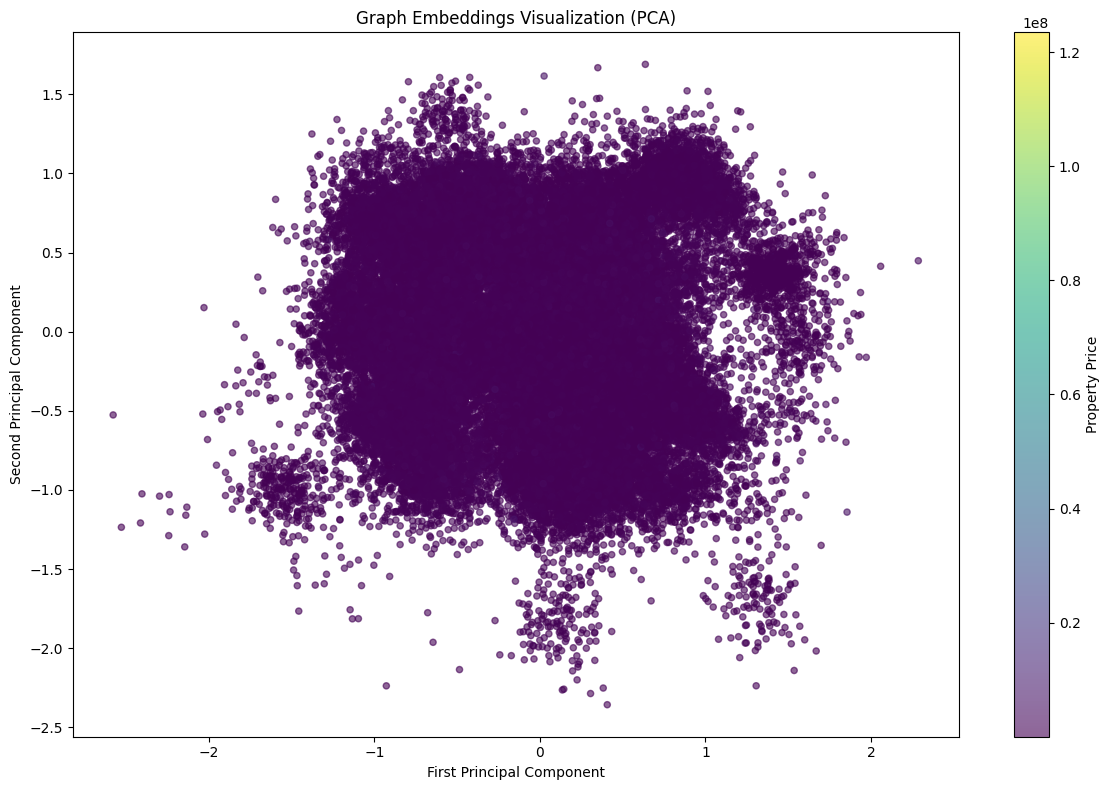

✓ Visualization saved as 'graph_embeddings_visualization.png'
  PCA explained variance: 18.30%


In [35]:
# Visualize embeddings using t-SNE or PCA
print("\nVisualizing embeddings...")

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(property_embeddings)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=graph_nodes_properties['price'].values,
                     cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Property Price')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Graph Embeddings Visualization (PCA)')
plt.tight_layout()
plt.savefig('graph_embeddings_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved as 'graph_embeddings_visualization.png'")
print(f"  PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")


## Save Graph Embeddings

In [36]:
# Save embeddings to CSV
output_filename = 'property_graph_embeddings.csv'
graph_embeddings_df.to_csv(output_filename, index=False)

print(f"\n✓ Graph embeddings saved to '{output_filename}'")
print(f"  Total properties: {len(graph_embeddings_df)}")
print(f"  Embedding dimensions: {property_embeddings.shape[1]}")



✓ Graph embeddings saved to 'property_graph_embeddings.csv'
  Total properties: 53220
  Embedding dimensions: 64


## Generate Embedding Statistics

In [39]:
# Generate statistics about the embeddings
print("\n" + "="*80)
print("GRAPH EMBEDDINGS STATISTICS")
print("="*80)

print(f"\nEmbedding Dimensions:")
print(f"  Total properties embedded: {len(graph_embeddings_df)}")
print(f"  Embedding vector size: {property_embeddings.shape[1]}")
print(f"  Total graph features: {property_embeddings.shape[0] * property_embeddings.shape[1]:,}")

print(f"\nEmbedding Distribution:")
embedding_cols = [col for col in graph_embeddings_df.columns if col.startswith('graph_emb_')]
embeddings_array = graph_embeddings_df[embedding_cols].values
print(f"  Mean: {embeddings_array.mean():.4f}")
print(f"  Std: {embeddings_array.std():.4f}")
print(f"  Min: {embeddings_array.min():.4f}")
print(f"  Max: {embeddings_array.max():.4f}")

print(f"\nGraph Structure Used:")
print(f"  Property nodes: {len(graph_nodes_properties)}")
print(f"  School nodes: {len(graph_nodes_schools)}")
print(f"  Station nodes: {len(graph_nodes_stations)}")
print(f"  Property-School connections: {len(graph_edges_property_school)}")
print(f"  Property-Station connections: {len(graph_edges_property_station)}")
print(f"  Station-Station connections: {len(graph_edges_station_station)}")

print(f"\nGRAPH EMBEDDINGS COMPLETE!")
print("="*80)



GRAPH EMBEDDINGS STATISTICS

Embedding Dimensions:
  Total properties embedded: 53220
  Embedding vector size: 64
  Total graph features: 3,406,080

Embedding Distribution:
  Mean: 0.0060
  Std: 0.2633
  Min: -2.9357
  Max: 2.7601

Graph Structure Used:
  Property nodes: 53220
  School nodes: 709
  Station nodes: 218
  Property-School connections: 52913
  Property-Station connections: 52913
  Station-Station connections: 47524

GRAPH EMBEDDINGS COMPLETE!


## Save Model and Scalers for Future Use

In [38]:
# Save model and preprocessing objects
print("\nSaving model and preprocessing objects...")

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'hidden_dim': hidden_dim,
    'embedding_dim': embedding_dim,
}, 'graph_embedding_model.pt')

# Save scalers and encoders
import pickle

preprocessing_objects = {
    'scaler_property': scaler_property,
    'scaler_school': scaler_school,
    'scaler_station': scaler_station,
    'le_protype': le_protype,
    'le_locality': le_locality,
    'le_state': le_state,
    'le_gender': le_gender,
    'le_school_type': le_school_type,
    'property_id_to_idx': property_id_to_idx,
    'school_id_to_idx': school_id_to_idx,
    'station_id_to_idx': station_id_to_idx
}

with open('graph_preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)

print("✓ Model saved as 'graph_embedding_model.pt'")
print("✓ Preprocessing objects saved as 'graph_preprocessing_objects.pkl'")



Saving model and preprocessing objects...
✓ Model saved as 'graph_embedding_model.pt'
✓ Preprocessing objects saved as 'graph_preprocessing_objects.pkl'


## Summary
We have successfully created graph embeddings using a heterogeneous Graph Neural Network ! The process included:​

1. Loaded all 6 graph files containing nodes and edges

2. Prepared node features for properties, schools, and train stations with proper scaling

3. Constructed a heterogeneous graph with multiple node types and edge relationships

4. Built and trained a GNN model using PyTorch Geometric's architecture​

5. Extracted 64-dimensional embeddings for each property that capture:

    - Structural property features

    - Proximity to schools and their quality

    - Accessibility to public transport

    - Neighborhood socio-economic indicators

    - Spatial relationships in the property network

Output File:

- property_graph_embeddings.csv - Contains property IDs, graph embeddings (64 dimensions), and prices

Next Steps:

- Step 3: Create text embeddings from property descriptions

- Step 4: Create image embeddings from property photos

- Step 5: Combine all embeddings for final price prediction